In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from scipy.stats import binom

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory (including wes, wgs, etc subfolders)
data_dir = ""

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
combined_maf = pd.read_csv(data_dir+"wgs/combined_noshared_FILTERED_muts_WGS.csv")

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (82,84,85,87,119) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
annot_dir = "../../data/scATACseq_annotations/"
sc_types = pd.read_csv(annot_dir+"scATAC_celltype_fracs.csv", index_col=0)

In [5]:
def plot_dist(maf, active_ax, plot_var="vaf", group_var=None, purity=None, common_norm=True, plot_color="darkgrey"):
    if group_var is None:
        sns.kdeplot(x=maf[plot_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
    else:
        sns.kdeplot(x=maf[plot_var], hue=maf[group_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
        
    if purity is not None:
        active_ax.axvline(x=purity/2, color="k", linestyle="dashed")
    active_ax.set_xlim(0,1)
    return

def estimate_ccf_purity(total_copies, mutant_copies, t_alt_count, t_depth):
    '''
    Estimates posterior probability of ppVAF values given sequencing data at a single mutation locus across a mesh sweeping across sample purity values from 0.01 to 1.
    params:
    total_copies: int total copy number at mutation locus
    mutant_copies: int minor allele copy number at mutation locus
    t_alt_count: int number of mutant reads at locus
    t_depth: int total number of reads at locus
    
    returns:
    100 x 1000 element numpy matrix of unnormalized ppVAF posterior probabilties at the mutation locus, where rows are sample purities from 0.01 to 1 and columns are ppVAF values from 0.001 to 1 (both evenly spaced)
    '''
    ccfs = np.linspace(0.001, 1, 1000).reshape(1, -1)
    purities = np.linspace(0.01, 1, 100).reshape(-1, 1)
    expected_vafs = purities * ccfs * mutant_copies / (2 * (1 - purities) + purities * total_copies)
    return(binom.pmf(t_alt_count, t_depth, expected_vafs))

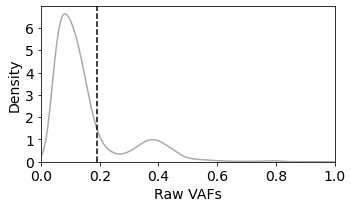

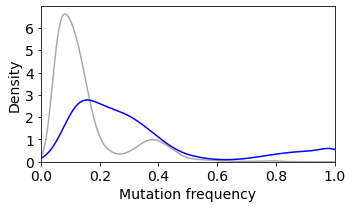

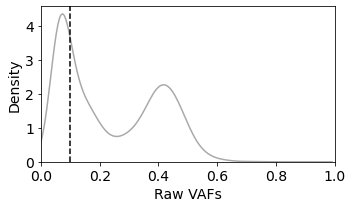

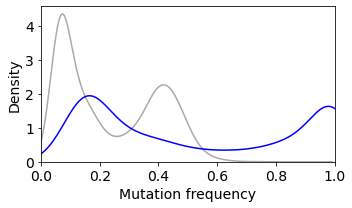

In [6]:
# EXTENDED DATA FIGURE 4a-b, g-h

fig, ax = plt.subplots(1,1,figsize=(5, 3))
to_plot = combined_maf[combined_maf["Tumor_Sample_Barcode"] == "G025"]
plot_purity = to_plot.iloc[0]["SequenzaPurity"]
plot_dist(to_plot, ax, purity=plot_purity)
plt.xlabel("Raw VAFs", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4b_G025_sequenza_purity.pdf")
plt.show()

fig, ax = plt.subplots(1,1,figsize=(5, 3))
to_plot = combined_maf[combined_maf["Tumor_Sample_Barcode"] == "G025"]
plot_dist(to_plot, ax)
plot_dist(to_plot, ax, plot_var="purity_ccf", plot_color="blue")
plt.xlabel("Mutation frequency", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4h_G025_ppVAF.pdf")
plt.show()

fig, ax = plt.subplots(1,1,figsize=(5, 3))
to_plot = combined_maf[combined_maf["Tumor_Sample_Barcode"] == "A002C010"]
plot_purity = to_plot.iloc[0]["SequenzaPurity"]
plot_dist(to_plot, ax, purity=plot_purity)
plt.xlabel("Raw VAFs", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4a_A002C010_sequenza_purity.pdf")
plt.show()

fig, ax = plt.subplots(1,1,figsize=(5, 3))
to_plot = combined_maf[combined_maf["Tumor_Sample_Barcode"] == "A002C010"]
plot_dist(to_plot, ax)
plot_dist(to_plot, ax, plot_var="purity_ccf", plot_color="blue")
plt.xlabel("Mutation frequency", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4g_A002C010_ppVAF.pdf")
plt.show()

In [7]:
all_consensus_purities = None
purities_to_add = combined_maf[["Tumor_Sample_Barcode", "SequenzaPurity"]].groupby("Tumor_Sample_Barcode").mean()
sample_to_stage = dict(zip(combined_maf["Tumor_Sample_Barcode"], combined_maf["Stage"]))
if all_consensus_purities is None:
    all_consensus_purities = purities_to_add
else:
    all_consensus_purities = pd.concat([all_consensus_purities, purities_to_add])
all_consensus_purities["Stage"] = [sample_to_stage[x] for x in all_consensus_purities.index]

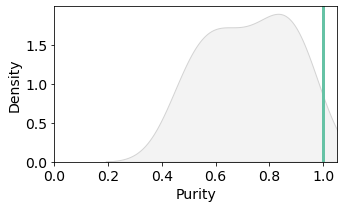

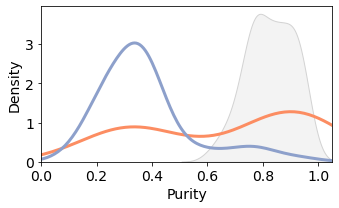

In [8]:
# EXTENDED DATA FIGURE 4c-d

fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.axvline(x=1, color=set2_colors[0], linewidth=3)
sns.kdeplot(sc_types[sc_types["DiseaseState"]=="Unaffected"]["epithelial"], common_norm=True, fill="lightgrey", color="lightgrey", ax=ax)
ax.set_xlim(0,1.05)
plt.xlabel("Purity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4c_mucosa_scrnaseq_purity.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.kdeplot(all_consensus_purities[all_consensus_purities["Stage"]=="Benign"]["SequenzaPurity"], common_norm=True, color=set2_colors[1], ax=ax, linewidth=3)
sns.kdeplot(all_consensus_purities[all_consensus_purities["Stage"]=="Dysplasia"]["SequenzaPurity"], common_norm=True, color=set2_colors[2], ax=ax, linewidth=3)
sns.kdeplot(sc_types[sc_types["DiseaseState"]=="Polyp"]["epithelial"], common_norm=True, fill="lightgrey", color="lightgrey", ax=ax)
ax.set_xlim(0,1.05)
plt.xlabel("Purity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4d_polyp_scrnaseq_purity.pdf")
plt.show()

In [9]:
t_alt = 20
t_depth = 100

prob_mat = estimate_ccf_purity(2, 1, t_alt, t_depth)

purity_dist = np.zeros(100)
purity_dist[80] = 1

normed_prob_mat = np.multiply(prob_mat, purity_dist.reshape((-1, 1)))
normed_prob_mat = np.divide(normed_prob_mat, np.sum(normed_prob_mat, axis=None))
marginalized = np.sum(normed_prob_mat, axis=0)

purity_dist = stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.1)
normed_prob_mat = np.multiply(prob_mat, purity_dist.reshape((-1, 1)))
normed_prob_mat = np.divide(normed_prob_mat, np.sum(normed_prob_mat, axis=None))
marginalized_uncertain = np.sum(normed_prob_mat, axis=0)

purity_dist = stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.3)
normed_prob_mat = np.multiply(prob_mat, purity_dist.reshape((-1, 1)))
normed_prob_mat = np.divide(normed_prob_mat, np.sum(normed_prob_mat, axis=None))
marginalized_more_uncertain = np.sum(normed_prob_mat, axis=0)

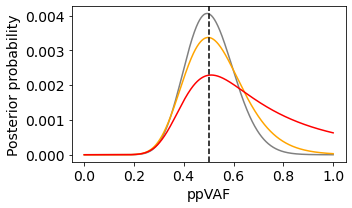

In [10]:
# EXTENDED DATA FIGURE 4f

true_frequency = (t_alt/t_depth)*2/0.8

fig, ax = plt.subplots(1,1, figsize=(5,3))
plt.plot(np.linspace(0.001, 1, 1000), marginalized, color="grey")
plt.plot(np.linspace(0.001, 1, 1000), marginalized_uncertain, "orange")
plt.plot(np.linspace(0.001, 1, 1000), marginalized_more_uncertain, "red")
plt.axvline(x=true_frequency, color="k", linestyle="dashed")
plt.xlabel("ppVAF", fontsize=14)
plt.ylabel("Posterior probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4f_ppVAF_sim.pdf")
plt.show()

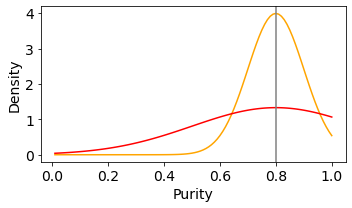

In [11]:
# EXTENDED DATA FIGURE 4e

fig, ax = plt.subplots(1,1, figsize=(5,3))
plt.plot(np.linspace(0.01, 1, 100), stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.1), color="orange")
plt.plot(np.linspace(0.01, 1, 100), stats.norm.pdf(np.linspace(0.01, 1, 100), loc=0.8, scale=0.3), color="red")
plt.axvline(x=0.8, color="grey")
plt.xlabel("Purity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED4e_purity_sim.pdf")
plt.show()